# IAU 2023/2024
## **Autori:** Laura Fulajtárová (50%), Bruno Kristián (50%)

# Fáza 3 - Strojové učenie 

In [1]:
import pandas as pd
import numpy as np
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from sklearn.tree import plot_tree
from IPython.display import Image
import copy
from collections import Counter
from IPython.display import display
from sklearn.neighbors import KNeighborsClassifier



### OneR algoritmus

Dočasne sme spojili dáta z trénovacej a testovacej množiny, aby sme mohli vytvoriť OneR model. 

In [2]:
X_train = pd.read_csv("X_train.csv", sep = ',')
y_train = pd.read_csv("y_train.csv", sep = ',')
X_test = pd.read_csv("X_test.csv", sep = ',')
y_test = pd.read_csv("y_test.csv", sep = ',')

merged_train_data = pd.concat([X_train, y_train], axis=1)
train_data = merged_train_data

merged_test_data = pd.concat([X_test, y_test], axis=1)
test_data = merged_test_data

One Rule algoritmus sme naprogramovali iba pre číselné hodnoty, pretože v dátach sme si v minulých fázach premenili pomocou encodingu všetky kategorické hodnoty na číselné.

In [3]:
def one_rule_algorithm(data, target_variable, explored_columns):
    best_feature = None
    best_accuracy = 0
    
    for feature in data.columns:
        if feature == target_variable or feature in explored_columns:
            continue
        
        mean_values = data.groupby(target_variable)[feature].mean()
        split_point = mean_values.mean()
        
        temp_data = data.copy()
        temp_data['prediction'] = temp_data[feature] > split_point
        
        accuracy = accuracy_score(temp_data[target_variable], temp_data['prediction'])
        precision = precision_score(temp_data[target_variable], temp_data['prediction'])
        recall = recall_score(temp_data[target_variable], temp_data['prediction'])
        
        if accuracy > best_accuracy:
            best_feature = feature
            best_accuracy = accuracy
            best_precision = precision
            best_recall = recall
            result = temp_data['prediction']
    
    return best_feature, best_accuracy, best_precision, best_recall, result

Spustíme algoritmus OneR s predikovanou premennou "ack" a vyhodnotíme metriky.

Na vyhodnotenie modelu sme použili nasledovné metriky:
- Accuracy - ako často klasiﬁkátor správne klasifikoval 

- Precision - koľko správne predikovaných príkladov bolo pozitívnych

- Recall - koľko pozitívnych príkladov bolo správne predikovaných

### OneR s jednou premennou

In [17]:
target_variable = 'ack'

oneR_train_data = copy.deepcopy(train_data)
oneR_test_data = copy.deepcopy(test_data)

best_feature, best_accuracy, best_precision, best_recall, prediction = one_rule_algorithm(oneR_train_data, target_variable, [])
print('Best column from OneR:', best_feature)
print('Test Accuracy:', best_accuracy)
print("\n")


testing = copy.deepcopy(test_data)[[best_feature, 'ack']]
best_feature, best_accuracy, best_precision, best_recall, prediction = one_rule_algorithm(testing, target_variable, [])

print('Test Accuracy:', best_accuracy)
print('Precision: ', best_precision)
print('Recall: ', best_recall)

Best column from OneR: page_activity_duration
Test Accuracy: 0.8994723687864482


Test Accuracy: 0.9056603773584906
Precision:  0.8571428571428571
Recall:  0.96


Vidíme, že algoritmus vyhodnotil "page_activity_duration" ako najlepšiu premennú pre predikciu "ack". Algoritmus na základe premennej "page_activity_duration" predikoval s presnosťou takmer 90%.

### OneR s viacerými premennými

Teraz skúsime spustiť OneR algoritmus viackrát a zistiť ktoré premenné najlepšie predikujú "ack".

Po zistení najlepších premenných ich použijeme na vytvorenie modelu. Pri vytváraní modelu prihliadame na presnosť predikcie danej premennej. Čím vyššia presnosť, tým má vyššiu váhu pri rozhodaovaní. 

In [5]:
target_variable = 'ack'
results = []
explored_columns = []
final_results = []

for _ in range(5):
    oneR_train_data = copy.deepcopy(train_data)
    best_feature, best_accuracy, best_precision, best_recall, prediction = one_rule_algorithm(oneR_train_data, target_variable, explored_columns)
    explored_columns.append(best_feature)
    results.append((best_accuracy, prediction.tolist()))

for result in results:
    if result[0] > 0.7:
        final_results.append(result[1])
        final_results.append(result[1])
    else:
        final_results.append(result[1])

combined_predictions = [Counter(sample).most_common(1)[0][0] for sample in zip(*final_results)]

overall_accuracy = accuracy_score(train_data[target_variable], combined_predictions)
overall_precision = precision_score(train_data[target_variable], combined_predictions, zero_division=0)
overall_recall = recall_score(train_data[target_variable], combined_predictions)

table_data = {
    "Algorithm": ["OneR"],
    "Accuracy": [overall_accuracy],
    "Precision": [overall_precision],
    "Recall": [overall_recall]
}

oneR_table = pd.DataFrame(table_data)

Najlepšie premenné k predikcií "ack"

In [6]:
table_data = {
    "Feature": explored_columns,
    "Accuracy": [result[0] for result in results]
}

accuracy_table = pd.DataFrame(table_data)
accuracy_table

,Feature,Accuracy
0,page_activity_duration,0.899472
1,pct_input,0.628159
2,pct_doubleclick,0.605110
3,wild_mouse_duration,0.581505
4,pct_click,0.575396


Výsledky metrík pre predikovanie premennej "ack" pomocou OneR algoritmu s viacerými premennými.

In [7]:
print('Overall Accuracy:', overall_accuracy)
print('Overall Precision:', overall_precision)
print('Overall Recall:', overall_recall)

Overall Accuracy: 0.8339350180505415
Overall Precision: 0.8271166370633511
Overall Recall: 0.82031708749266


### Scikit-learn Klasifikátory

Stromový klasifikátor Random Forest.

In [18]:
clf = RandomForestClassifier(min_samples_split = 6, max_depth = 10)
clf.fit(X_train, y_train)

overfit = clf.predict(X_train)
predictions = clf.predict(X_test)

overfit_accuracy = accuracy_score(y_train, overfit)

accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)

print(f"Train Accuracy: {overfit_accuracy:.2f}")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

table_data = {
    "Algorithm": ["Random Forest"],
    "Accuracy": [accuracy],
    "Precision": [precision],
    "Recall": [recall]
}

RF_table = pd.DataFrame(table_data)

feature_importances = clf.feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1]
top_5_features_rf = sorted_indices[:5]
top_5_importances = feature_importances[top_5_features_rf]

feature_names = X_test.columns.values

top_5_feature_names_rf = [feature_names[i] for i in top_5_features_rf]

c:\users\default.laptop-e7uruv4i\desktop\iau\iau\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Train Accuracy: 0.97
Accuracy: 0.95
Precision: 0.93
Recall: 0.97


Stromový klasifikátor Gradient Boosting.

In [9]:
from sklearn.ensemble import GradientBoostingClassifier
import pandas as pd
import numpy as np

gb_model = GradientBoostingClassifier(n_estimators=100, random_state=1)

gb_model.fit(X_train, y_train)

gb_overfit = gb_model.predict(X_train)
gb_y_pred = gb_model.predict(X_test)

gb_overfit_accuracy = accuracy_score(y_train, gb_overfit)
gb_accuracy = accuracy_score(y_test, gb_y_pred)
gb_precision = precision_score(y_test, gb_y_pred)
gb_recall = recall_score(y_test, gb_y_pred)

print(f"Train Accuracy: {gb_overfit_accuracy:.2f}")
print(f"Accuracy: {gb_accuracy:.2f}")
print(f"Precision: {gb_precision:.2f}")
print(f"Recall: {gb_recall:.2f}")

table_data = {
    "Algorithm": ["Gradient Boosting"],
    "Accuracy": [gb_accuracy],
    "Precision": [gb_precision],
    "Recall": [gb_recall]
}

GB_table = pd.DataFrame(table_data)

feature_importances = gb_model.feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1]
top_5_features_gb = sorted_indices[:5]
top_5_importances = feature_importances[top_5_features_gb]
feature_names = X_test.columns.values

top_5_feature_names = [feature_names[i] for i in top_5_features_gb]

c:\users\default.laptop-e7uruv4i\desktop\iau\iau\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train Accuracy: 0.97
Accuracy: 0.96
Precision: 0.94
Recall: 0.98


### Nestromový algoritmus

Pre nestromový algoritmus sme si vybrali KNN klasifikátor.

Najskôr si dáta scalujeme a normalizujeme, aby KNN klasifikátor pracoval efektívnejšie.

In [10]:
from sklearn.preprocessing import MinMaxScaler, PowerTransformer

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(X_train)
train_data_scaled = pd.DataFrame(scaled_data, columns=X_train.columns)

power = PowerTransformer(method='yeo-johnson', standardize=True) 
X_train_normalised = power.fit_transform(train_data_scaled)
X_train_scaled_normalised = pd.DataFrame(X_train_normalised, columns=X_train.columns)

scaled_test_data = scaler.transform(X_test)
test_data_scaled = pd.DataFrame(scaled_test_data, columns=X_test.columns)

normalized_test_data = power.transform(test_data_scaled)
test_data_scaled_normalized = pd.DataFrame(normalized_test_data, columns=X_test.columns)

Pri stromových klasifikačných algoritmoch sme nemuseli použiť feature selection, pretože si s tým poradili samé. Pri nestromových algoritmoch je to však inak.

In [11]:
columns_to_keep = [
    'page_activity_duration', 'pct_doubleclick', 'pct_mouse_click', 'wild_mouse_duration',
    'pct_mouse_move', 'pct_input', 'pct_click', 'session_start', 
    'scroll_move_total_rel_distance', 'pct_scroll_move'
]

X_train_filtered = X_train_scaled_normalised[columns_to_keep]
X_test_filtered = test_data_scaled_normalized[columns_to_keep]

KNN klasifikátor

In [12]:
knn_model = KNeighborsClassifier(n_neighbors=10)

knn_model.fit(X_train_filtered, y_train)

knn_y_pred = knn_model.predict(X_test_filtered)
knn_overfit = knn_model.predict(X_train_filtered)

knn_ovefit_accuracy = accuracy_score(y_train, knn_overfit)
knn_accuracy = accuracy_score(y_test, knn_y_pred)
knn_precision = precision_score(y_test, knn_y_pred)
knn_recall = recall_score(y_test, knn_y_pred)

print(f"Train Accuracy: {knn_ovefit_accuracy:.2f}")
print(f"Accuracy: {knn_accuracy:.2f}")
print(f"Precision: {knn_precision:.2f}")
print(f"Recall: {knn_recall:.2f}")

table_data_knn = {
    "Algorithm": ["K-Nearest Neighbors"],
    "Accuracy": [knn_accuracy],
    "Precision": [knn_precision],
    "Recall": [knn_recall]
}

knn_table = pd.DataFrame(table_data_knn)

from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(score_func=f_classif, k=5)
selector.fit(X_train_filtered, y_train)
top_5_indices = selector.get_support(indices=True)
top_5_features_knn = X_train_filtered.columns[top_5_indices]

c:\users\default.laptop-e7uruv4i\desktop\iau\iau\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Train Accuracy: 0.96
Accuracy: 0.97
Precision: 0.96
Recall: 0.97


c:\users\default.laptop-e7uruv4i\desktop\iau\iau\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


#### Porovnanie výsledkov

In [13]:
display(oneR_table, RF_table, GB_table, knn_table)

,Algorithm,Accuracy,Precision,Recall
0,OneR,0.833935,0.827117,0.820317


,Algorithm,Accuracy,Precision,Recall
0,Random Forest,0.958935,0.940909,0.974118


,Algorithm,Accuracy,Precision,Recall
0,Gradient Boosting,0.962264,0.943311,0.978824


,Algorithm,Accuracy,Precision,Recall
0,K-Nearest Neighbors,0.965594,0.95814,0.969412


Z porovnania výsledkov vidíme, že najlepšie výsledky dosiahol Gradient Boosting klasifikátor.

Náš oneR algoritmus dosiahol presnosť 83%. Dôvodom je jednoduchosť algoritmu a potreba predikovať pomocou viacerých premenných. Keďže najlepší atribút má presnosť okolo 90% a ostané atribúty majú presnosť len okolo 60%, tak pri predikovaní pomocou viacerých atribútov sa presnosť zníži.

OneR algoritmus predikuje s precíznosťou 82%, čo je o viac ako 10% menej ako Gradient Boosting klasifikátor alebo Random Forest klasifikátor.

Náš algoritmus je o 15% horší ako ako Gradient Boosting klasifikátor alebo Random Forest klasifikátor v predikovaní pozitívnych príkladov zo všetkých pozitívnych príkladov.

In [14]:
print("One Rule Algorithm:")
for column in explored_columns:
    print(column)


print("\n")
print("Random Forest:")
for column in top_5_feature_names_rf:
    print(column)


print("\n")
print("Gradient Boosting:")
for column in top_5_feature_names:
    print(column)

print("\n")
print("K Nearest Neighbours:")
for column in top_5_features_knn:
    print(column)

One Rule Algorithm:
page_activity_duration
pct_input
pct_doubleclick
wild_mouse_duration
pct_click


Random Forest:
page_activity_duration
pct_doubleclick
pct_input
pct_mouse_click
wild_mouse_duration


Gradient Boosting:
page_activity_duration
pct_doubleclick
pct_mouse_click
pct_click
pct_mouse_move


K Nearest Neighbours:
page_activity_duration
pct_doubleclick
pct_mouse_move
pct_input
pct_click


Vidíme, že algoritmy sa podobajú vo výbere atribútov, ktoré najlepšie predikujú "ack". Najlepšie atribúty sú "page_activity_duration", "pct_doubleclick", "pct_" a "page_activity_mean".

#### Vizualizácia natrénovaných pravidiel

Vizualizujeme si Random Forest klasifikátor.

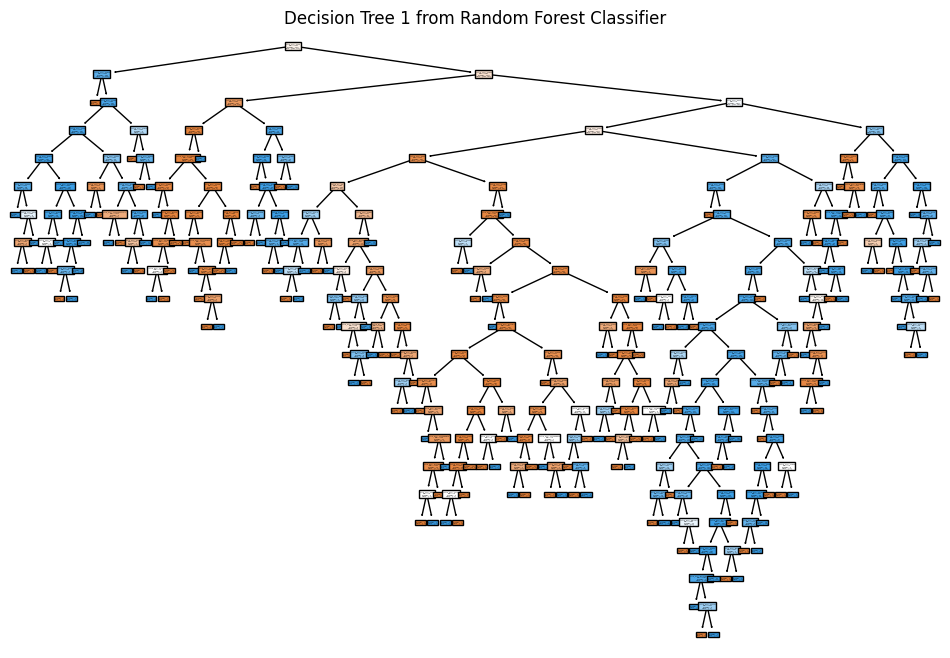

In [15]:
tree_index = 0
plt.figure(figsize=(12, 8))
plot_tree(clf.estimators_[tree_index], filled=True, feature_names=[f"feature_{i}" for i in range(X_test.shape[1])])
plt.title(f"Decision Tree {tree_index + 1} from Random Forest Classifier")
plt.show()

Vizualizácia pravidiel pre Random Forest klasifikátor na základe accuracy.

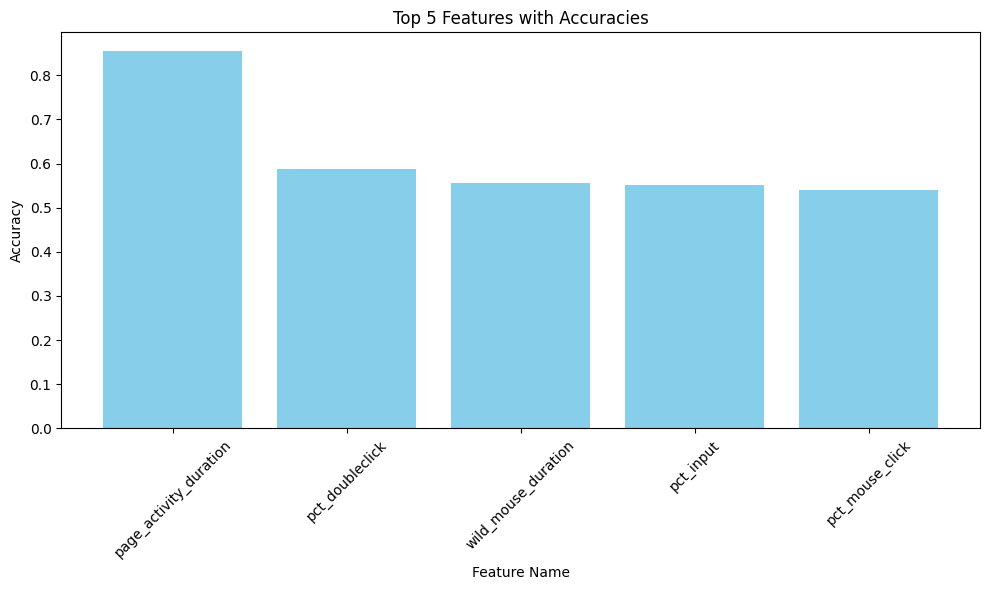

In [16]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

feature_accuracies = []

for i in range(X_train.shape[1]):
    X_train_single_feature = X_train.iloc[:, i:i+1]  # Assuming X_train is a DataFrame
    X_test_single_feature = X_test.iloc[:, i:i+1]    # Assuming X_test is a DataFrame
    
    clf_single_feature = RandomForestClassifier()
    clf_single_feature.fit(X_train_single_feature, y_train.values.ravel())  # Convert y_train to a 1D array
    
    predictions_single_feature = clf_single_feature.predict(X_test_single_feature)
    
    accuracy_single_feature = accuracy_score(y_test, predictions_single_feature)
    feature_accuracies.append((X_train.columns[i], accuracy_single_feature))

sorted_features = sorted(feature_accuracies, key=lambda x: x[1], reverse=True)

top_5_feature_names = [feat[0] for feat in sorted_features[:5]]
top_5_accuracies = [feat[1] for feat in sorted_features[:5]]

plt.figure(figsize=(10, 6))
plt.bar(top_5_feature_names, top_5_accuracies, color='skyblue')
plt.xlabel('Feature Name')
plt.ylabel('Accuracy')
plt.title('Top 5 Features with Accuracies')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
